# BiasBusters Stereotype Detection Model 

In [16]:
!python3 -m pip install datasets

Python(41463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Loading in our synthetically generated data and preparing the structure for the model

In [17]:
from datasets import load_dataset, Dataset

# Load CSV file as a dataset
datasetnew = load_dataset('csv', data_files='stereotypes_new.csv')
datasetnew = datasetnew.remove_columns(['Unnamed: 0'])
datasetnew = datasetnew['train']

# Step 1: Rename columns
datasetnew = datasetnew.rename_column("Sentence", "Text")

datasetnew = Dataset.from_dict({
    "text": datasetnew["Text"],
    "label": datasetnew["Label"]
})

# Change labels to 1 if "yes" and 0 if "no"
def update_labels(example):
    if 'stereotype' in example['label']:
        example["category"] = 0
    elif 'unrelated' in example['label']:
        example['category'] = 1
    else:
        example['category'] = 2
    return example

# Apply the transformation
datasetnew = datasetnew.map(update_labels)

# Verify the result
print(datasetnew)

Map: 100%|██████████| 2600/2600 [00:00<00:00, 48953.13 examples/s]

Dataset({
    features: ['text', 'label', 'category'],
    num_rows: 2600
})


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert to Pandas for stratified sampling
df = datasetnew.to_pandas()

# Perform stratified sampling using sklearn
train_, eval_ = train_test_split(
    df, 
    train_size=0.5,  # Adjust the fraction of data you want to sample
    stratify=df["label"],  # Use the label column for stratification
    random_state=42
)

# Convert back to Hugging Face Dataset
dataset_new_train = Dataset.from_pandas(train_)
dataset_new_eval = Dataset.from_pandas(eval_)
# Inspect the result

In [19]:
import pandas as pd

# Load the dataset
splits = {'test': 'test.csv'}
hai_test_data = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["test"])

hai_test_data_focus= hai_test_data[['text', 'label']].copy()
hai_test_data_focus=hai_test_data_focus.sample(n=1300, random_state=42)

In [20]:
hai_test_data_focus_ds = Dataset.from_pandas(hai_test_data_focus)
hai_test_data_focus_ds = hai_test_data_focus_ds.map(update_labels)
hai_test_data_focus_ds = hai_test_data_focus_ds.remove_columns(["__index_level_0__"])

Map: 100%|██████████| 1300/1300 [00:00<00:00, 34807.06 examples/s]


In [21]:
train_set = dataset_new_train
test_set = dataset_new_eval

train_set = train_set.remove_columns(['label'])
test_set = test_set.remove_columns(['label'])
hai_set = hai_test_data_focus_ds.remove_columns(['label'])

train_set = Dataset.from_dict({
    "label": train_set["category"],
    "text": train_set["text"]
})

test_set = Dataset.from_dict({
    "label": test_set['category'],
    'text': test_set['text']
})

hai_set = Dataset.from_dict({
    "label": hai_set['category'],
    'text': hai_set['text']
})


In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_set_tokenized = train_set.map(tokenize_function, batched=True)
test_set_tokenized = test_set.map(tokenize_function, batched=True)
hai_set_tokenized = hai_test_data_focus_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 1300/1300 [00:00<00:00, 13241.65 examples/s]


In [23]:
from sklearn.metrics import f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='macro')  # Use macro F1
    return {"f1": f1}

In [24]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)
    
# Apply the tokenizer to the dataset
tokenized_train_dataset = train_set.map(tokenize_function, batched=True)
tokenized_test_dataset = test_set.map(tokenize_function, batched=True)
tokenized_hai_dataset = hai_set.map(tokenize_function, batched=True)

# Load pre-trained ALBERT model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2", 
    num_labels=3, 
    # label2id=label2id,
    # id2label=id2label
)

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)

# Fine-tuning the model and save the best model
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    num_train_epochs=3,
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Map: 100%|██████████| 1300/1300 [00:00<00:00, 12556.38 examples/s]
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/84/9htrvh0j4hgg6hgt52_0rtpr0000gn/T/ipykernel_38769/2011728651.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon WARNING @ 13:42:12] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 13:42:12] [setup] RAM Tracking...
[codecarbon INFO @ 13:42:12] [setup] GPU Tracking...
[codecarbon INFO @ 13:42:12] No GPU found.
[codecarbon INFO @ 13:42:12] [setup] CPU Tracking...
Python(41465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingfac

{'loss': 0.4771, 'grad_norm': 4.612357139587402, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}







[codecarbon INFO @ 14:08:58] Energy consumed for RAM : 0.012016 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:08:58] Energy consumed for all CPUs : 0.075752 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:08:58] 0.087768 kWh of electricity used since the beginning.



[codecarbon INFO @ 14:09:02] Energy consumed for RAM : 0.003007 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:09:02] Energy consumed for all CPUs : 0.018956 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:09:02] 0.021963 kWh of electricity used since the beginning.













[codecarbon INFO @ 14:09:13] Energy consumed for RAM : 0.012044 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:09:13] Energy consumed for all CPUs : 0.075929 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:09:13] 0.087973 kWh of electricity used since the beginning.



[codecarbon INFO @ 14:09:17] Energy consumed for RAM : 0.003035 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:09:17] Energy consumed for all CPUs : 0.019134 kWh. Tota

{'eval_loss': 0.274464875459671, 'eval_f1': 0.6300432186664668, 'eval_runtime': 76.5518, 'eval_samples_per_second': 16.982, 'eval_steps_per_second': 1.071, 'epoch': 1.0}


[codecarbon INFO @ 14:10:13] Energy consumed for RAM : 0.012156 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:10:13] Energy consumed for all CPUs : 0.076638 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:13] 0.088794 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:10:17] Energy consumed for RAM : 0.003148 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:10:17] Energy consumed for all CPUs : 0.019842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:17] 0.022990 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:10:29] Energy consumed for RAM : 0.012185 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:10:29] Energy consumed for all CPUs : 0.076818 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:29] 0.089003 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:10:32] Energy consumed for RAM : 0.003176 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:10:32] Energy consumed for all CPUs : 0.020019 kWh. Total CPU Power : 42.5 W
[co

{'loss': 0.2344, 'grad_norm': 0.4937492907047272, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}













[codecarbon INFO @ 14:35:45] Energy consumed for RAM : 0.015021 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:35:45] Energy consumed for all CPUs : 0.094716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:35:45] 0.109737 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:35:47] Energy consumed for RAM : 0.006016 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:35:47] Energy consumed for all CPUs : 0.037911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:35:47] 0.043926 kWh of electricity used since the beginning.













[codecarbon INFO @ 14:36:00] Energy consumed for RAM : 0.015050 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:36:00] Energy consumed for all CPUs : 0.094893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:36:00] 0.109942 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:36:02] Energy consumed for RAM : 0.006044 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:36:02] Energy consumed for all CPUs : 0.038088 kWh. 

{'eval_loss': 0.18359361588954926, 'eval_f1': 0.8713498130487206, 'eval_runtime': 80.5679, 'eval_samples_per_second': 16.135, 'eval_steps_per_second': 1.018, 'epoch': 2.0}


[codecarbon INFO @ 14:37:00] Energy consumed for RAM : 0.015162 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:37:00] Energy consumed for all CPUs : 0.095601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:00] 0.110763 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:02] Energy consumed for RAM : 0.006156 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:37:02] Energy consumed for all CPUs : 0.038796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:02] 0.044953 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:15] Energy consumed for RAM : 0.015190 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:37:15] Energy consumed for all CPUs : 0.095779 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:15] 0.110969 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:17] Energy consumed for RAM : 0.006185 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 14:37:17] Energy consumed for all CPUs : 0.038973 kWh. Total CPU Power : 42.5 W
[co

{'loss': 0.1116, 'grad_norm': 0.07940670847892761, 'learning_rate': 0.0, 'epoch': 3.0}






[codecarbon INFO @ 15:19:18] Energy consumed for RAM : 0.019908 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:19:18] Energy consumed for all CPUs : 0.125557 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:18] 0.145466 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:18] Energy consumed for RAM : 0.010909 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:19:18] Energy consumed for all CPUs : 0.068735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:18] 0.079644 kWh of electricity used since the beginning.





[codecarbon INFO @ 15:19:33] Energy consumed for RAM : 0.019937 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:19:33] Energy consumed for all CPUs : 0.125734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:33] 0.145671 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:33] Energy consumed for RAM : 0.010937 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:19:33] Energy consumed for all CPUs : 0.068912 kWh. Total CPU Power : 4

{'eval_loss': 0.13902035355567932, 'eval_f1': 0.9340107709038808, 'eval_runtime': 152.6309, 'eval_samples_per_second': 8.517, 'eval_steps_per_second': 0.537, 'epoch': 3.0}


                                                   
100%|██████████| 246/246 [1:39:26<00:00, 18.70s/it][codecarbon INFO @ 15:21:43] Energy consumed for RAM : 0.011179 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:21:43] Energy consumed for all CPUs : 0.070436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:43] 0.081615 kWh of electricity used since the beginning.
/Users/erinsarlak/Desktop/BiasBusters/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
100%|██████████| 246/246 [1:39:27<00:00, 24.26s/it]


{'train_runtime': 5966.9148, 'train_samples_per_second': 0.654, 'train_steps_per_second': 0.041, 'train_loss': 0.2743497166207166, 'epoch': 3.0}


TrainOutput(global_step=246, training_loss=0.2743497166207166, metrics={'train_runtime': 5966.9148, 'train_samples_per_second': 0.654, 'train_steps_per_second': 0.041, 'total_flos': 93211810099200.0, 'train_loss': 0.2743497166207166, 'epoch': 3.0})

# ------


### Generalizing on prevoulsy unseen data

In [25]:
from sklearn.metrics import f1_score

# Making predictions on the test set
preds = trainer.predict(tokenized_hai_dataset).predictions.argmax(-1)
f1 = f1_score(tokenized_hai_dataset['label'], preds, average='macro')
print(f"Macro F1 Score: {f1:.3f}")

  2%|▏         | 2/82 [00:02<01:19,  1.00it/s][codecarbon INFO @ 15:21:48] Energy consumed for RAM : 0.020190 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:21:48] Energy consumed for all CPUs : 0.127329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:48] 0.147518 kWh of electricity used since the beginning.
  7%|▋         | 6/82 [00:16<03:33,  2.81s/it][codecarbon INFO @ 15:22:03] Energy consumed for RAM : 0.020218 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:22:03] Energy consumed for all CPUs : 0.127507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:22:03] 0.147724 kWh of electricity used since the beginning.
 15%|█▍        | 12/82 [00:32<02:46,  2.37s/it][codecarbon INFO @ 15:22:18] Energy consumed for RAM : 0.020246 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:22:18] Energy consumed for all CPUs : 0.127684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:22:18] 0.147929 kWh of electricity used since the beginning.
 27%|██▋       | 22/82 [00:46<01:34,  1.57s/it][cod

Macro F1 Score: 0.344


### Bias Assessment

In [26]:
from transformers import pipeline

# Load the text classification pipeline
classifier = pipeline("text-classification", model=trainer.model, tokenizer=trainer.tokenizer,top_k=3)

def assess_bias(model, counterfactuals):
    bias_results = {}
    for text in counterfactuals:
        prediction = model(text)
        bias_results[text] = prediction
    return bias_results


# Creating demographic counterfactuals (example)
counterfactuals = ["Males are usually good at playing chess.", "Females are often bad drivers."]
bias_results = assess_bias(classifier, counterfactuals)

bias_results

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'Males are usually good at playing chess.': [[{'label': 'LABEL_0',
    'score': 0.9933712482452393},
   {'label': 'LABEL_2', 'score': 0.004893976263701916},
   {'label': 'LABEL_1', 'score': 0.00173477316275239}]],
 'Females are often bad drivers.': [[{'label': 'LABEL_0',
    'score': 0.9984377026557922},
   {'label': 'LABEL_2', 'score': 0.0010517826303839684},
   {'label': 'LABEL_1', 'score': 0.0005104794399812818}]]}

### Utilizing the shap explainer

In [28]:
import shap

explainer = shap.Explainer(classifier)
shap_values = explainer(counterfactuals)

shap_values_stereotype = shap_values[:, :, "LABEL_2"].values
shap_vectors = []

# Save SHAP values in vectors for subsequent calculation
for index, values in enumerate(shap_values_stereotype):
    # Trim to exclude whitespace and punctuation 
    trimmed_values = values[1:-2]
    shap_vectors.append(trimmed_values)
    print(f"Sentence {index+1} SHAP vector: {trimmed_values}")

shap.plots.text(shap_values[:, :, "LABEL_2"])


Sentence 1 SHAP vector: [-0.12000846 -0.22882925  0.23903726 -0.20463732  0.04057559  0.03216694
  0.02185567]
Sentence 2 SHAP vector: [-0.00219397 -0.05614572 -0.05335631 -0.31095876  0.00752182]


### Using the Lime Text Explainer

In [30]:
from lime.lime_text import LimeTextExplainer

def predict_proba(texts):
    preds = classifier(texts)
    probabilities = np.array([[pred['score'] for pred in preds_single] for preds_single in preds])
    return probabilities

explainer = LimeTextExplainer(class_names=["LABEL_2", "LABEL_1", "LABEL_0"])

lime_values_per_sentence = []

for idx, sentence in enumerate(counterfactuals):
    exp = explainer.explain_instance(sentence, predict_proba, num_features=50, num_samples=100, top_labels=1)
    feature_importances = exp.as_list(label=0)
    
    lime_values = [weight for _, weight in feature_importances]
    lime_values_per_sentence.append(lime_values)
    
    print(f"LIME values for Sentence {idx+1} 'stereotype':", lime_values)

    exp.show_in_notebook() 

LIME values for Sentence 1 'stereotype': [0.12722701456046775, 0.0760980125509045, 0.07020321779311776, 0.04636797421314639, 0.03773901961609794, 0.028050311207052904, 0.015644226096648672]


LIME values for Sentence 2 'stereotype': [0.08112623682883617, 0.075113842884055, 0.07085871262380666, 0.06310056393952389, -0.00911379395242711]


### Comparing the cosine similarity between the SHAP and LIME scores

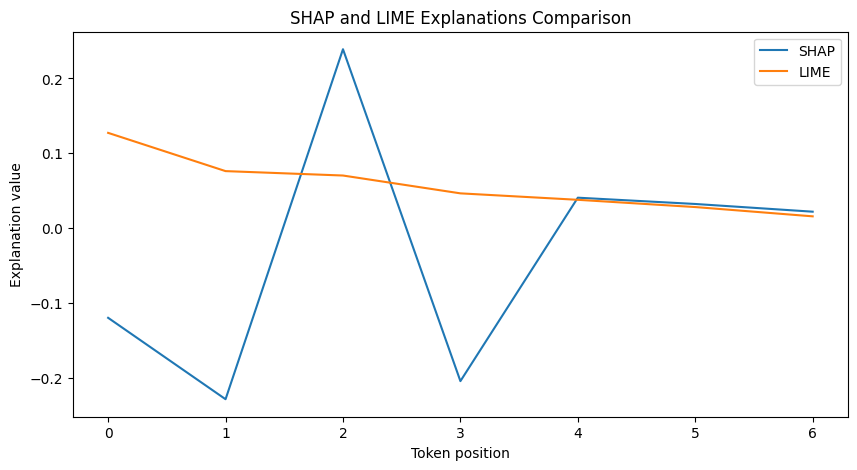

Cosine similarity between SHAP and LIME for Sentence 1 (Males are usually good at playing chess.): -0.3099344050050451
Cosine similarity between SHAP and LIME for Sentence 2 (Females are often bad drivers.): -0.5955133853392288


[codecarbon INFO @ 15:42:49] Energy consumed for RAM : 0.022552 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:42:49] Energy consumed for all CPUs : 0.142208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:49] 0.164760 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:04] Energy consumed for RAM : 0.022580 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:43:04] Energy consumed for all CPUs : 0.142385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:04] 0.164965 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:19] Energy consumed for RAM : 0.022608 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:43:19] Energy consumed for all CPUs : 0.142562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:19] 0.165170 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:34] Energy consumed for RAM : 0.022636 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 15:43:34] Energy consumed for all CPUs : 0.142739 kWh. Total CPU Power : 42.5 W
[co

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Plot and compare SHAP and LIME explanations
plt.figure(figsize=(10, 5))
plt.plot(shap_vectors[0], label="SHAP")
plt.plot(lime_values_per_sentence[0], label="LIME")
plt.legend()
plt.xlabel("Token position")
plt.ylabel("Explanation value")
plt.title("SHAP and LIME Explanations Comparison")
plt.show()


# Calculating cosine similarity between SHAP and LIME vectors
for idx, (shap_vec, lime_vec) in enumerate(zip(shap_vectors, lime_values_per_sentence)):
    shap_vec_array = np.array(shap_vec)
    lime_vec_array = np.array(lime_vec)

    similarity = cosine_similarity([shap_vec_array], [lime_vec_array])[0][0]
    print(f"Cosine similarity between SHAP and LIME for Sentence {idx + 1} ({counterfactuals[idx]}): {similarity}")